In [ ]:
!pip install hdbscan
!pip install umap-learn

     |████████████████████████████████| 6.4MB 6.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311729 sha256=d799b94df66903ead94092b0d34a80a0d2b48010ebfbb8d9561d8046e23ba0c6
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 1.2MB 12.4MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=07702217367fc750fde75ff415d63932c6a178e2a8737efc24908472f0087c45
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=45c225f3f2c23a3104017e82578fc49ac5abe2ca8fa884d

In [ ]:
import re
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import hdbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10
output_notebook()

#### Download the cleaned and transformed Kaggle Dataset for analysis

In [ ]:
!gdown --id 1q3_jJmGt2ehOtq1YeljzR3aMN49w94dJ #KaggleMovies.csv

Downloading...
From: https://drive.google.com/uc?id=1q3_jJmGt2ehOtq1YeljzR3aMN49w94dJ
To: /content/KaggleMovies.csv
3.83MB [00:00, 18.0MB/s]


#### Read in the dataset

In [ ]:
df = pd.read_csv("/content/KaggleMovies.csv")

In [ ]:
df.head()

id  keywords  adult  ...  genreNum  titleNum                        title
0    862  2.732882      0  ...      2147       894                    toy story
1   8844  3.245939      0  ...      2278       719                      jumanji
2  15602  2.430012      0  ...      1318      1483             grumpier old men
3  31357  2.852449      0  ...      1803      1614            waiting to exhale
4  11862  3.213356      0  ...       609      2336  father of the bride part ii

[5 rows x 12 columns]

#### Normalize the data

In [ ]:
ss = StandardScaler()
scaled = ss.fit_transform(df[['keywords',	'adult',	'original_language',	'popularity',	'revenue',	'vote_average',	'vote_count',	'castNum',	'genreNum',	'titleNum']])
df2 = pd.DataFrame(scaled, index=df.index, columns=df.columns[1:-1])
df2.head()

keywords     adult  original_language  ...   castNum  genreNum  titleNum
0  0.847260 -0.014077          -0.394233  ... -0.377262  0.918893 -0.510445
1  1.226231 -0.014077          -0.394233  ...  0.650365  1.073379 -0.641393
2  0.623544 -0.014077          -0.394233  ... -0.520308 -0.058728 -0.069712
3  0.935579 -0.014077          -0.394233  ... -0.392040  0.513222  0.028312
4  1.202164 -0.014077          -0.394233  ... -0.427182 -0.894836  0.568567

[5 rows x 10 columns]

#### Kmeans

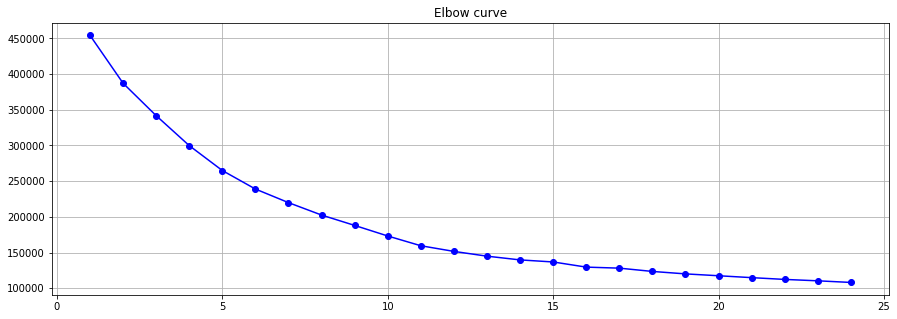

In [ ]:
distortions = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df2)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 25), distortions, 'bo-')
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 11)
kmeans.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=11, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
z = kmeans.cluster_centers_

In [ ]:
kmeans.labels_

array([10,  6,  2, ...,  1,  5,  5], dtype=int32)

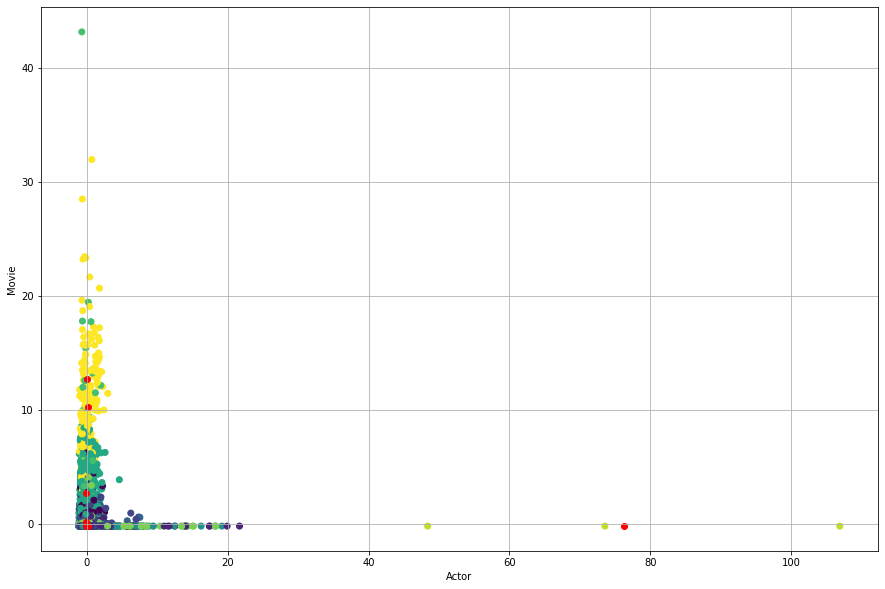

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.scatter(x = 'titleNum' , y = 'revenue' , data = df2, c = kmeans.labels_)
plt.scatter(x = z[:,9], y =z[:,4], c = 'red')
plt.xlabel("Actor")
plt.ylabel("Movie")
plt.show()

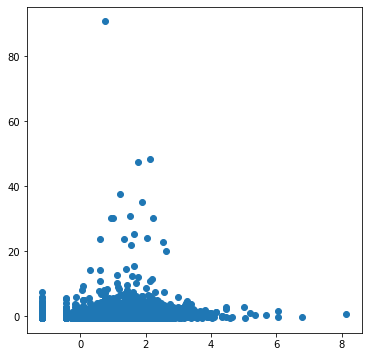

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(df2.iloc[:, 0], df2.iloc[:, 3])

Kmeans showed that no clear clusters could be seen utilizing titleNum and revenue

## DBScan with PCA

In [ ]:
df3 = StandardScaler().fit_transform(df2)

In [ ]:
pca = PCA(n_components = 2)
df3_pca = pca.fit_transform(df3)
df3_pca = pd.DataFrame(df3_pca)
df3_pca.columns = ['P1', 'P2']
df3_pca.head()

P1        P2
0  10.514273  3.010588
1   6.459092  0.938200
2   0.718726 -0.720910
3   0.902263 -0.676265
4   1.086304  0.179491

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df3_pca)
labels = db.labels_
print(labels)

[-1  0  0 ...  0  0  0]


##### Number of clusters (Including noisy cluster -1)

In [ ]:
n_clusters = len(set(labels)) 
n_clusters

5

In [ ]:
n_noise = list(labels).count(-1)
n_noise

473

##### Number of points per cluster

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{-1: 473, 0: 44909, 1: 20, 2: 17, 3: 10}

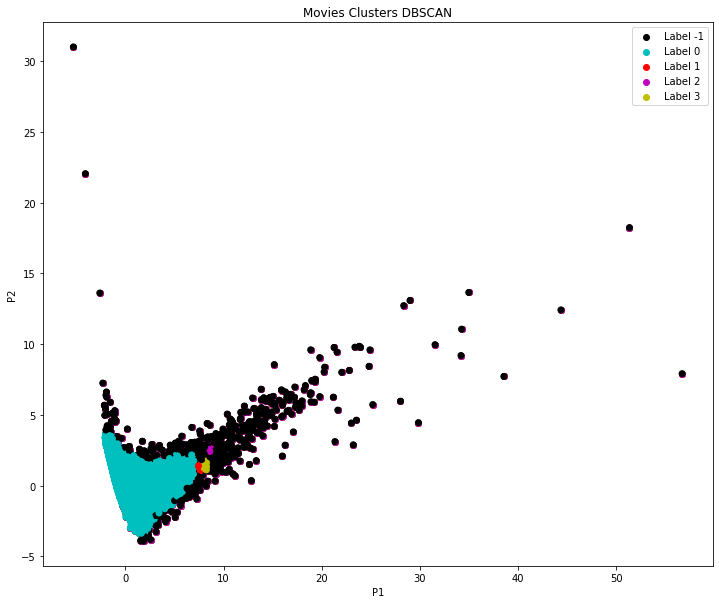

In [ ]:
def applyColor(x):
    if x == -1:
        return 'k'
    elif x == 0:
        return 'c'
    elif x == 1:
        return 'r'
    elif x == 2:
        return "y"
    elif x == 3:
        return "m"

colors = list(map(lambda x: applyColor(x), labels))

plt.figure(figsize =(12, 10))
k = plt.scatter(df3_pca['P1'], df3_pca['P2'], color ='k');
c = plt.scatter(df3_pca['P1'], df3_pca['P2'], color ='c');
r = plt.scatter(df3_pca['P1'], df3_pca['P2'], color ='r');
m = plt.scatter(df3_pca['P1'], df3_pca['P2'], color ='y');
y = plt.scatter(df3_pca['P1'], df3_pca['P2'], color ='m');

ax = plt.scatter(df3_pca['P1'], df3_pca['P2'], c=colors)
# ax = plt.scatter(df3_pca['P1'], df3_pca['P2'], c=labels)
plt.xlabel('P1')
plt.ylabel('P2')
plt.legend((k, c, r, y, m), ('Label -1', 'Label 0', 'Label 1', 'Label 2', 'Label 3'))
plt.title('Movies Clusters DBSCAN')
plt.show()

### HDBSCAN with PCA

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=20, metric='euclidean')
hdb_labels = hdb.fit_predict(df3_pca)

In [ ]:
hdb_labels

array([-1, -1,  7, ...,  7,  7,  7])

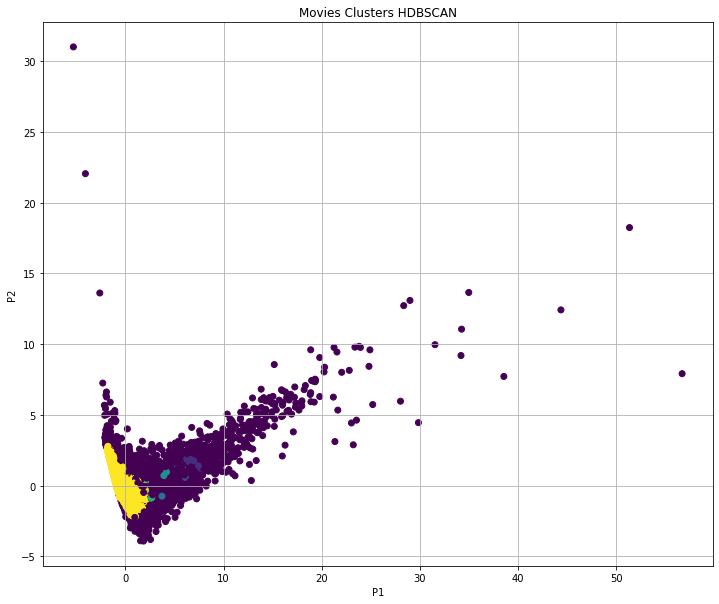

In [ ]:
plt.figure(figsize=(12,10))
plt.grid(True)
plt.scatter(x = 'P1' ,y = 'P2' , data = df3_pca, c = hdb_labels)
plt.xlabel("P1")
plt.ylabel("P2")
plt.title('Movies Clusters HDBSCAN')
plt.show()

In [ ]:
unique, counts = np.unique(hdb_labels, return_counts=True)
dict(zip(unique, counts))

{-1: 3559, 0: 27, 1: 20, 2: 21, 3: 32, 4: 42, 5: 31, 6: 35, 7: 41662}

DBSCAN & HDBSCAN with PCA did not show us the appropriate clusters, therefore we moved onto UMAP.

### Kmeans using MinMaxScaler and UMAP 

In [ ]:
ss = MinMaxScaler()
df2 = ss.fit_transform(df[['keywords',	'adult',	'original_language',	'popularity',	'revenue',	'vote_average',	'vote_count',	'castNum',	'genreNum',	'titleNum']])

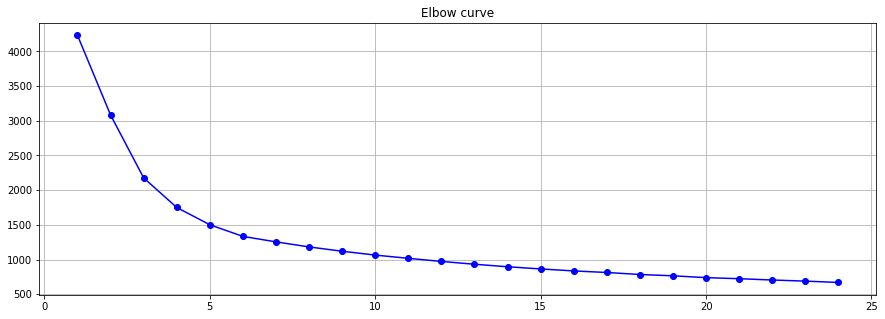

In [ ]:
distortions = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters = k, random_state=2)
    kmeans.fit(df2)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15, 5))
plt.plot(range(1, 25), distortions, 'bo-')
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [ ]:
clf=KMeans(n_clusters=5, random_state=2)
clf.fit(df2)

print(clf.labels_)

z = clf.cluster_centers_
print(z)

[0 0 4 ... 3 1 1]
[[ 1.95845068e-01 -4.36391374e-18  2.21927519e-01  1.02431918e-02
   1.26091504e-02  6.02358637e-01  2.14559809e-02  2.26029383e-02
   3.68445921e-01  1.02967873e-02]
 [ 6.32646470e-02  5.70125428e-04  2.43622923e-01  4.43728057e-04
   5.52223942e-06  2.83124287e-02  4.70277529e-05  1.06853288e-02
   1.40607853e-01  1.22643590e-02]
 [ 8.68232040e-02 -3.95733793e-18  7.90781168e-01  2.67595429e-03
   7.13507882e-04  6.24737529e-01  1.40189411e-03  1.97123406e-02
   1.82598234e-01  1.08449367e-02]
 [ 8.13474906e-02  3.91542678e-04  2.20762320e-01  3.39639629e-03
   7.06949034e-04  4.98444009e-01  1.79693470e-03  1.45284484e-02
   1.62043391e-01  1.01298514e-02]
 [ 1.37349441e-01  1.26935771e-04  2.31511591e-01  5.29771460e-03
   2.61815436e-03  6.93220995e-01  6.71696750e-03  1.75945235e-02
   1.48482753e-01  1.06706934e-02]]


## Display Kmeans Clusters using UMAP and Bokeh

In [ ]:
df3 = umap.UMAP(n_components=2).fit_transform(df2)

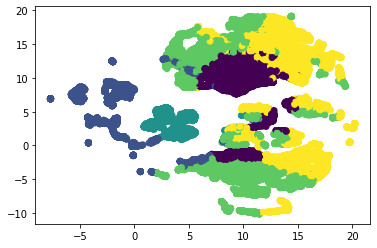

In [ ]:
plt.scatter(df3[:,0], df3[:,1], c= clf.labels_)
plt.show()

In [ ]:
movies_df = pd.DataFrame(df3, columns=('x', 'y'))
movies_df['class'] = [str(x) for x in clf.labels_]
movies_df['title'] = df['title'].values

datasource = ColumnDataSource(movies_df)

color_mapping = CategoricalColorMapper(factors=[str(x) for x in np.unique(clf.labels_)],
                                       palette=Spectral10)

plt_figure = figure(
    title='UMAP Kmeans clustering for the movies dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plt_figure.add_tools(HoverTool(tooltips=[
            ('Title', '@title'),
           ]))

plt_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
)

show(plt_figure)

In [ ]:
silScore = silhouette_score(df2, clf.labels_)

In [ ]:
silScore

0.253073451818501

Clusters are not appropriately separated, therefore this method was not used.

## HDBSCAN using manhattan and UMAP

In [ ]:
sil_scores = {}
def best_sil(train):
    min_cluster = [20, 30, 40,50, 60]
    min_samples= [10, 15, 20]
    for a in min_cluster :
      for b in min_samples :
        hdb = hdbscan.HDBSCAN(min_cluster_size=a, min_samples=b, metric='manhattan')
        hdb_labels = hdb.fit_predict(train)
        silScore = silhouette_score(train, hdb_labels)
        
        sil_scores[a] = silScore
        sil_scores[str(str(a)+'_'+str(b))] = silScore

In [ ]:
best_sil(df3)

In [ ]:
best_params = max(sil_scores, key=lambda k: sil_scores[k])
print('best hdbscan params is ' + str(best_params) + ' with a sil score of ' + str(sil_scores[best_params]))

best hdbscan params is 10_1 with a sil score of 0.2335149


In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan')
hdb_labels = hdb.fit_predict(df3)

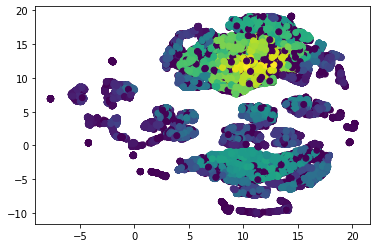

In [ ]:
plt.scatter(df3[:,0], df3[:,1], c= hdb_labels)
plt.show()

In [ ]:
df4 = umap.UMAP(n_neighbors=10, min_dist=0.05, n_components=2, metric='manhattan', random_state=42).fit_transform(df3)

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan')
hdb_labels = hdb.fit_predict(df4)

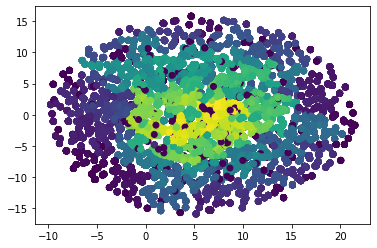

In [ ]:
plt.scatter(df4[:,0], df4[:,1], c= hdb_labels)
plt.show()

In [ ]:
silScore = silhouette_score(df4, hdb_labels, metric='manhattan')
silScore

0.6050387754931847

### UMAP KMeans

In [ ]:
mapper = umap.UMAP(n_components=2)

In [ ]:
df5 = mapper.fit_transform(df2)

In [ ]:
df5

array([[ 6.162259  ,  4.2978024 ],
       [ 6.6285295 ,  3.5237885 ],
       [ 4.95622   , -1.1065509 ],
       ...,
       [ 8.120557  , 16.52448   ],
       [20.687178  ,  1.2299387 ],
       [21.710026  ,  0.49896827]], dtype=float32)

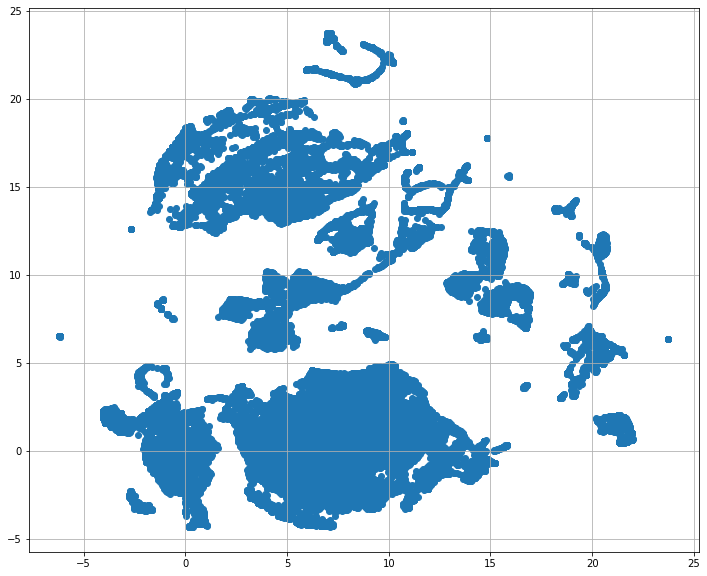

In [ ]:
plt.figure(figsize=(12,10))
plt.grid(True)
plt.scatter(df5[:, 0] ,df5[:, 1])
plt.show()

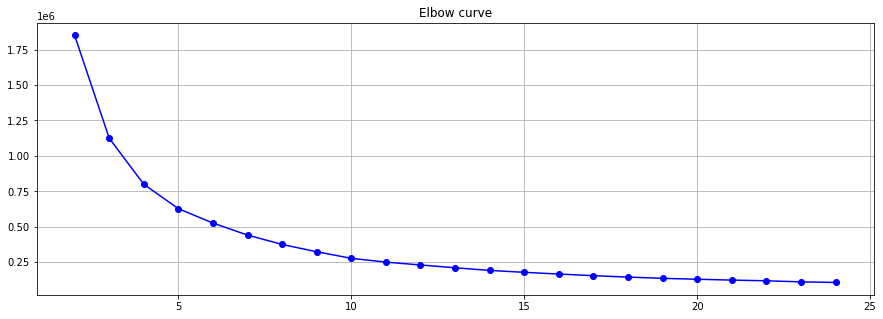

In [ ]:
distortions = []
for k in range(2,25):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df5)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15,5))
plt.plot(range(2,25), distortions, 'bo-')
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [ ]:
clf=KMeans(n_clusters=5, random_state=2)
clf.fit(df5)

print(clf.labels_)

z = clf.cluster_centers_
print(z)

[1 1 1 ... 4 2 2]
[[ 6.538542   9.762358 ]
 [ 8.366598   0.6279173]
 [17.067636   8.5599   ]
 [ 0.4536543  0.2797246]
 [ 4.163719  16.712286 ]]


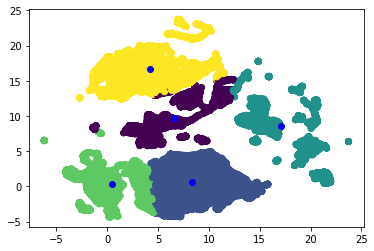

In [ ]:
plt.scatter(df5[:,0], df5[:,1], c= clf.labels_)
plt.scatter(z[:,0], z[:,1], c='blue')
plt.show()

In [ ]:
movies_df = pd.DataFrame(df5, columns=('x', 'y'))
movies_df['class'] = [str(x) for x in clf.labels_]
movies_df['title'] = df['title'].values

datasource = ColumnDataSource(movies_df)

color_mapping = CategoricalColorMapper(factors=[str(x) for x in np.unique(clf.labels_)],
                                       palette=Spectral10)

plt_figure = figure(
    title='UMAP Kmeans clustering for the movies dataset',
    plot_width=600,
    plot_height=600,
    tools=('pan, wheel_zoom, reset')
)

plt_figure.add_tools(HoverTool(tooltips=[
            ('Title', '@title'),
           ]))

plt_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='class', transform=color_mapping),
)

show(plt_figure)


In [ ]:
silScore = silhouette_score(df5, clf.labels_, metric='euclidean')
silScore

0.4393554

In [ ]:
distances = clf.fit_transform(df5)

In [ ]:
distances

array([[ 5.477495 ,  4.281024 , 11.70866  ,  6.9809113, 12.574322 ],
       [ 6.239218 ,  3.377418 , 11.5904   ,  6.9751725, 13.416846 ],
       [10.983484 ,  3.8261023, 15.496021 ,  4.711142 , 17.836452 ],
       ...,
       [ 6.944716 , 15.898467 , 11.978513 , 17.963116 ,  3.961292 ],
       [16.522291 , 12.3352785,  8.174926 , 20.255823 , 22.643494 ],
       [17.775948 , 13.34405  ,  9.302172 , 21.257502 , 23.89026  ]],
      dtype=float32)

In [ ]:
df6_data = {'X_Axis': df5[:,0],
       'Y_Axis': df5[:,1],
       'Label': df['title'],
       'Cluster': clf.labels_ + 1,
        'Distance to Cluster 1': distances[:,0],
        'Distance to Cluster 2': distances[:,1],
        'Distance to Cluster 3': distances[:,2],
        'Distance to Cluster 4': distances[:,3],
        'Distance to Cluster 5': distances[:,4]}

In [ ]:
df6 = pd.DataFrame(df6_data)

In [ ]:
df6.head(20)

X_Axis     Y_Axis  ... Distance to Cluster 4  Distance to Cluster 5
0   12.242569  10.066461  ...              6.980911              12.574322
1   11.648536  10.453339  ...              6.975173              13.416846
2   12.183207  14.359950  ...              4.711142              17.836452
3   10.322092  12.094173  ...              7.197356              16.274206
4   12.689964  17.340708  ...              1.083046              17.925673
5   11.748726  10.436055  ...              6.844407              13.315679
6   11.936825  13.225465  ...              4.605078              14.001986
7   13.086662   0.470778  ...             15.391480               2.783334
8    8.767223  10.488712  ...              9.339552              16.124447
9   11.311884  10.553066  ...              7.071314              13.446370
10  11.244694  11.739863  ...              6.416969              15.517399
11  15.993511   8.139559  ...              7.389080              20.975180
12  11.730375   9.800618  ...              7.403927              13.975245
13  13.392649  13.304260  ...              3.626194              16.192961
14   9.818959  14.067639  ...              6.992882              18.569424
15  13.338506  12.505142  ...              3.933244              14.865066
16  12.812832  12.691005  ...              4.372860              15.038782
17  12.341886  13.299032  ...              4.372882              16.095722
18  11.121425  10.970269  ...              6.861170              14.682178
19   9.026682  12.512315  ...              8.499866              17.144270

[20 rows x 9 columns]

#### Make DF with only movies from cluster 1

In [ ]:
c1_df = df6[df6['Cluster'] == 1]

In [ ]:
del c1_df["Distance to Cluster 2"]
del c1_df["Distance to Cluster 3"]
del c1_df["Distance to Cluster 4"]
del c1_df["Distance to Cluster 5"]
del c1_df["X_Axis"]
del c1_df["Y_Axis"]

In [ ]:
c1_df = c1_df.rename(columns={'Distance to Cluster 1': 'Distance'})

In [ ]:
c1_df.head()

Label  Cluster  Distance
28  the city of lost children        1  3.705268
32           wings of courage        1  2.353321
52                   lamerica        1  1.087689
57                the postman        1  0.189009
58           the confessional        1  2.606866

#### Make DF with only movies from cluster 2

In [ ]:
c2_df = df6[df6['Cluster'] == 2]

In [ ]:
del c2_df["Distance to Cluster 1"]
del c2_df["Distance to Cluster 3"]
del c2_df["Distance to Cluster 4"]
del c2_df["Distance to Cluster 5"]
del c2_df["X_Axis"]
del c2_df["Y_Axis"]

In [ ]:
c2_df = c2_df.rename(columns={'Distance to Cluster 2': 'Distance'})

In [ ]:
c2_df.head()

Label  Cluster  Distance
0          toy story        2  4.281024
1            jumanji        2  3.377418
2   grumpier old men        2  3.826102
3  waiting to exhale        2  0.757925
5               heat        2  3.534659

#### Make DF with only movies from cluster 3

In [ ]:
c3_df = df6[df6['Cluster'] == 3]

In [ ]:
del c3_df["Distance to Cluster 1"]
del c3_df["Distance to Cluster 2"]
del c3_df["Distance to Cluster 4"]
del c3_df["Distance to Cluster 5"]
del c3_df["X_Axis"]
del c3_df["Y_Axis"]

In [ ]:
c3_df = c3_df.rename(columns={'Distance to Cluster 3': 'Distance'})

In [ ]:
c3_df.head()

Label  Cluster  Distance
29                 shanghai triad        3  1.343059
55        kids of the round table        3  7.779337
81                 antonia's line        3  3.695141
83    last summer in the hamptons        3  7.910293
107  headless body in topless bar        3  4.492513

#### Make DF with only movies from cluster 4

In [ ]:
c4_df = df6[df6['Cluster'] == 4]

In [ ]:
del c4_df["Distance to Cluster 1"]
del c4_df["Distance to Cluster 2"]
del c4_df["Distance to Cluster 3"]
del c4_df["Distance to Cluster 5"]
del c4_df["X_Axis"]
del c4_df["Y_Axis"]

In [ ]:
c4_df = c4_df.rename(columns={'Distance to Cluster 4': 'Distance'})

In [ ]:
c4_df.head()

Label  Cluster  Distance
4   father of the bride part ii        4  1.083046
13                        nixon        4  3.626194
15                       casino        4  3.933244
25                      othello        4  1.840637
27                   persuasion        4  2.755519

#### Make DF with only movies from cluster 5

In [ ]:
c5_df = df6[df6['Cluster'] == 5]

In [ ]:
del c5_df["Distance to Cluster 1"]
del c5_df["Distance to Cluster 2"]
del c5_df["Distance to Cluster 4"]
del c5_df["Distance to Cluster 3"]
del c5_df["X_Axis"]
del c5_df["Y_Axis"]

In [ ]:
c5_df = c5_df.rename(columns={'Distance to Cluster 5': 'Distance'})

In [ ]:
c5_df.head()

Label  Cluster  Distance
7             tom and huck        5  2.783334
36  across the sea of time        5  4.266479
50          guardian angel        5  2.375769
66                two bits        5  0.953358
76               nico icon        5  4.647469

#### Finding nearest movie based on distance

In [ ]:
def find_10_nearest(array, value):
    top10 = []
    array = np.asarray(array)
    arrayCopy = array;
    for i in range(10) or i in range(len(array)):
      index = (np.abs(arrayCopy - value)).argmin()
      top10.append(arrayCopy[index])
      arrayCopy = np.delete(arrayCopy, index)
    return top10

In [ ]:
def get_closest_movies(movie):
  movieRow = df6[df6['Label'] == movie]
  if (len(movieRow) == 0):
    print("Movie not found")
    return
  cluster = movieRow.iloc[0]['Cluster']
  if cluster == 1:
    newDf = c1_df
  elif cluster == 2:
    newDf = c2_df
  elif cluster == 3:
    newDf = c3_df
  elif cluster == 4:
    newDf = c4_df
  elif cluster == 5:
    newDf = c5_df
  else:
    print("Movie not found")
    return
  newRow = newDf[newDf['Label'] == movie]
  clusterDistances = newDf.loc[:,'Distance']
  distanceArr = clusterDistances.values
  top10 = find_10_nearest(distanceArr, newRow.iloc[0]['Distance'])
  print(top10)
  top10Names = []
  for i in range(len(top10)):
    newRow = newDf[newDf['Distance'] == top10[i]]
    top10Names.append(newRow.iloc[0]['Label'])
  return top10Names

In [ ]:
value = input("Enter a movie")
get_closest_movies(value)

Enter a movieiron man 2
[4.3717422, 4.3715067, 4.371461, 4.372026, 4.3713202, 4.3710685, 4.370649, 4.3729744, 4.3703785, 4.3733854]


['iron man 2',
 'munchie strikes back',
 'the man who loved women',
 'hotel california',
 'knowing',
 'despicable me 2',
 'turtles forever',
 'cat chaser',
 'my blind brother',
 'gallowwalkers']

The recommended movies do not relate to the movie queried